# Mapper-CSV
This file simply converts the indicated positions to a csv to use for the dataloader.

In [15]:
import os.path as path
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import json
from scipy.spatial import distance
import numpy as np
from glob import glob
%matplotlib inline

In [8]:
# Set data to be processed
DROOT = './0_data'

# Database.json
DB_SRC = path.join("0_framemapper/api/db.json")
DB_DST = path.join(DROOT, "2_procfootage/eyetracker/labels.csv")
EYE_SRC = path.join(DROOT, "1_rawfootage/20210406_Amsterdam_eye/2021-04-06_10-59-05.json")

RND_LBL = path.join(DROOT, "2_procfootage/round_img/labels.csv")

,true_x,true_y
frame,,
146,2892,889


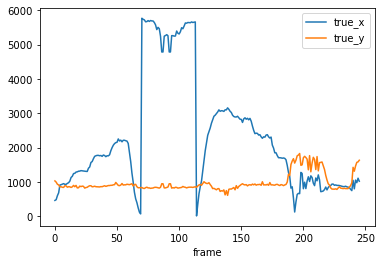

In [34]:
# Since the app always displays the root image as 1680px wide
#  we need to scale up the position linearly.
actual_width = 5792
projed_width = 1680
factor = actual_width / projed_width

# Image is projected as 300x300px from the center, so we need to sub that aswell.
coords = json.load(open(DB_SRC))['360']
coords = [ [int(k), int((v[0]-150)*factor), int((v[1]-150)*factor)]
           for k,v in coords.items() ]

coords = pd.DataFrame(coords, columns=['frame', 'true_x', 'true_y'])
coords = coords.set_index('frame').sort_index()
coords.loc[coords.true_x < 0, 'true_x'] += actual_width

coords.plot()

coords.sample()

### Determine the closest frame from the base footage

In [51]:
def distance_wrap_around(coord1, coord2, max_x):
    
    coord1_around = (coord1[0] - max_x, coord1[1])
    coord2_around = (coord2[0] - max_x, coord2[1])
    
    dist = min(distance.euclidean(coord1, coord2), 
               distance.euclidean(coord1_around, coord2),
               distance.euclidean(coord1, coord2_around))
    
    return dist

coords_base_df = pd.read_csv(RND_LBL, index_col='frame')
coords_base = list(zip(coords_base_df.x, coords_base_df.y))
coords_frme = list(zip(coords.true_x, coords.true_y))

closest_frme = [np.argmin([distance_wrap_around(base, frame, 5792)
                            for base in coords_base])
                for frame in coords_frme]
closest_frme = pd.DataFrame(closest_frme, columns=['base_id'])
closest_frme['base_id'] = closest_frme['base_id'].astype('Int64')
closest_frme['base_x'] = closest_frme.base_id.apply(lambda i: coords_base[i][0])
closest_frme['base_y'] = closest_frme.base_id.apply(lambda i: coords_base[i][1])

closest_frme.sample(5)

,base_id,base_x,base_y
24,71,1267,905
176,75,1991,905
191,165,905,1448
9,69,905,905
87,90,4706,905


### Attach eye-tracking details

In [52]:
# Read and process logging data from Kexxu OpenEye
moments = []
with open(EYE_SRC) as file:
    for line in file:
        if 'eyetracking' in line:
            moments.append(json.loads(line[61:]))
moments = [{x['Feature']:x['Value'] for x in y} for y in moments]
moments = pd.DataFrame(moments)
moments = moments.drop(columns=['timestamp_ms'])
moments.tail()

,pupil_pos_x,pupil_pos_y,pupil_rel_pos_x,pupil_rel_pos_y,eye_left_pos_x,eye_left_pos_y,eye_right_pos_x,eye_right_pos_y
242,-0.055846,-0.032142,0.089373,0.371711,-0.330534,0.014444,0.159627,0.001888
243,-0.054556,-0.041589,0.096455,0.305466,-0.329855,0.000763,0.167794,-0.010009
244,-0.063643,-0.037841,0.042088,0.347830,-0.335065,0.005457,0.155663,-0.006641
245,-0.060947,-0.038294,0.062103,0.359512,-0.332708,0.007022,0.149600,-0.005692
246,-0.057190,-0.038816,0.096268,0.363024,-0.331491,0.008073,0.150711,-0.005700


In [53]:
# Merge into one eyetracking file with true and estimated locations
eyetracker = pd.merge(coords, closest_frme, left_index=True, right_index=True)
eyetracker = pd.merge(eyetracker, moments, left_index=True, right_index=True)
eyetracker.index.name = "frame"
eyetracker.to_csv(DB_DST)
eyetracker

,true_x,true_y,base_id,base_x,base_y,pupil_pos_x,pupil_pos_y,pupil_rel_pos_x,pupil_rel_pos_y,eye_left_pos_x,eye_left_pos_y,eye_right_pos_x,eye_right_pos_y
frame,,,,,,,,,,,,,
0,458,1027,99,543,1086,-0.055980,-0.087626,0.001697,0.102346,-0.325064,-0.035832,0.208162,-0.050219
1,479,992,67,543,905,-0.035286,-0.078033,0.120430,0.182746,-0.312461,-0.033111,0.222686,-0.029655
2,596,930,67,543,905,-0.036567,-0.073361,0.109807,0.235064,-0.313025,-0.030144,0.219648,-0.026873
3,679,910,68,724,905,-0.037230,-0.074613,0.100189,0.227346,-0.316794,-0.032723,0.218169,-0.025598
4,906,855,69,905,905,-0.031673,-0.075576,0.127936,0.222449,-0.312994,-0.034538,0.223552,-0.025603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,796,1310,132,724,1267,-0.041238,-0.025678,0.178196,0.421638,-0.318023,0.028398,0.173493,0.016748
242,1051,1461,166,1086,1448,-0.055846,-0.032142,0.089373,0.371711,-0.330534,0.014444,0.159627,0.001888
243,975,1568,165,905,1448,-0.054556,-0.041589,0.096455,0.305466,-0.329855,0.000763,0.167794,-0.010009
